In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
os.getenv("GROQ_API_KEY")
model="moonshotai/kimi-k2-instruct-0905"

In [2]:
from langchain_groq import ChatGroq
llm = ChatGroq(model_name=model)
llm.invoke("Hello")

/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 27, 'total_tokens': 38, 'completion_time': 0.021566724, 'completion_tokens_details': None, 'prompt_time': 0.009437758, 'prompt_tokens_details': None, 'queue_time': 0.287409482, 'total_time': 0.031004482}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'stop', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bb800-fe9a-7fd2-bd69-60a3f8fa23b0-0', usage_metadata={'input_tokens': 27, 'output_tokens': 11, 'total_tokens': 38})

In [3]:
from langchain.tools import tool

@tool
def multiply(a: int, b: int) -> int:
    """Multiply two numbers together."""
    return a * b

def add(a: int, b: int) -> int:
    """Add two numbers together."""
    return a + b

def divide(a: int, b: int) -> int:
    """Divide two numbers together."""
    return a / b



In [81]:
!pip install youtube_search
!pip install duckduckgo-search
!pip install -U ddgs
!pip install yfinance

import yfinance as yf

from langchain_community.tools import YouTubeSearchTool
from langchain_community.tools import DuckDuckGoSearchRun

duckduckgo_tool = DuckDuckGoSearchRun()
youtube_tool = YouTubeSearchTool()

duckduckgo_tool.invoke("What is the capital of Finland?")



"4 Jan 2026 · Helsinki (Swedish: Helsingfors) is the capital and most populous city in Finland. It is on the shore of the Gulf of Finland and is the seat of southern Finland ... 19 Mar 2025 · Helsinki is the capital of Finland. A lively city rich in history, Helsinki was founded in 1550 and became the capital of Finland in 1812. 5 Aug 2025 · Helsinki, Finland's capital, is a vibrant city by the Baltic Sea. It's full of cool neighbourhoods, hot saunas, cute islands, cozy cafes, amazing restaurants ... 2 Jan 2026 · Helsinki is the capital of Finland and the country's leading seaport and industrial city. 5 Aug 2025 · 🇫🇮 Helsinki, Finland's capital, is a vibrant city by the Baltic Sea. It's full of cool neighbourhoods, hot saunas, cute islands, cozy cafes, amazing ..."

In [82]:
@tool
def get_stock_price(ticker:str)->str:
    """
    Fetches the previous closing price of a given stock ticker from Yahoo Finance.

    Args:
        ticker (str): The stock ticker symbol (e.g., 'AAPL', 'TSLA', 'NIFTY.BO').

    Returns:
        str: A message with the stock's previous closing price.
    """
    try:
        stock = yf.Ticker(ticker)
        price = stock.info.get('previousClose')
        if price is None:
            return f"Could not fetch price for ticker '{ticker}'."
        return f"The last closing price of {ticker.upper()} was ${price:.2f}."
    except Exception as e:
        return f"An error occurred while fetching stock data: {str(e)}"

In [83]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode, tools_condition

tools = [add, multiply, divide, duckduckgo_tool, youtube_tool, get_stock_price]
llm_with_tools=llm.bind_tools(tools)

def function_1(state: MessagesState):
    # This appends a system message to the history correctly
    user_message = state["messages"]
    input_question = ["You are a helpful assistant tasked to answer questions using the tools provided and performing arithmetic operations on set of input."]+user_message
    res = llm_with_tools.invoke(input_question)
    return {"messages": res}



In [84]:
builder = StateGraph(MessagesState)

builder.add_node("llm_decision_step", function_1)

builder.add_node("tool_step", ToolNode(tools))

builder.add_edge(START, "llm_decision_step")

builder.add_conditional_edges(
    "llm_decision_step", 
    tools_condition, 
    {
        "tools": "tool_step",  # Map the condition's result to your node name
        END: END               # Map the end condition to the END state
    }
)

builder.add_edge("tool_step", "llm_decision_step")


react_graph = builder.compile()

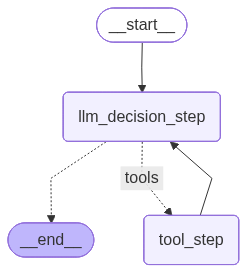

In [85]:
from IPython.display import Image, display
display(Image(react_graph.get_graph().draw_mermaid_png()))

In [86]:
message = [HumanMessage(content="what is 2 times narendra modi's age?")]
react_graph.invoke({"messages": message})


{'messages': [HumanMessage(content="what is 2 times narendra modi's age?", additional_kwargs={}, response_metadata={}, id='c272a31e-f53d-4d5b-b9c9-7eb844df9f31'),
  AIMessage(content="I need to find Narendra Modi's age first. Let me search for that information.", additional_kwargs={'tool_calls': [{'id': 'functions.duckduckgo_search:0', 'function': {'arguments': '{"query":"Narendra Modi age"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 581, 'total_tokens': 623, 'completion_time': 0.148445931, 'completion_tokens_details': None, 'prompt_time': 0.041624681, 'prompt_tokens_details': {'cached_tokens': 256}, 'queue_time': 0.283942669, 'total_time': 0.190070612}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bb83d-13e8-7493-80c0-9e98d48e415a-0', t

In [87]:
message = [HumanMessage(content="Who is mr. bearst? Give is top 5 videos.")]
res = react_graph.invoke({"messages": message})
res


{'messages': [HumanMessage(content='Who is mr. bearst? Give is top 5 videos.', additional_kwargs={}, response_metadata={}, id='de688602-09e2-4039-a30b-b39d6e7006bf'),
  AIMessage(content="I'll search for information about Mr. Bearst and find his top videos for you.", additional_kwargs={'tool_calls': [{'id': 'functions.duckduckgo_search:0', 'function': {'arguments': '{"query":"Mr. Bearst who is"}', 'name': 'duckduckgo_search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 42, 'prompt_tokens': 583, 'total_tokens': 625, 'completion_time': 0.157515007, 'completion_tokens_details': None, 'prompt_time': 0.016991524, 'prompt_tokens_details': {'cached_tokens': 512}, 'queue_time': 0.283765656, 'total_time': 0.174506531}, 'model_name': 'moonshotai/kimi-k2-instruct-0905', 'system_fingerprint': 'fp_05df423bab', 'service_tier': 'on_demand', 'finish_reason': 'tool_calls', 'logprobs': None, 'model_provider': 'groq'}, id='lc_run--019bb83d-1fd2-7683-8069-c48456feec9d-0

In [88]:
for m in res["messages"]:
    m.pretty_print()


================================ Human Message =================================

Who is mr. bearst? Give is top 5 videos.
================================== Ai Message ==================================

I'll search for information about Mr. Bearst and find his top videos for you.
Tool Calls:
  duckduckgo_search (functions.duckduckgo_search:0)
 Call ID: functions.duckduckgo_search:0
  Args:
    query: Mr. Bearst who is
================================= Tool Message =================================
Name: duckduckgo_search

Major Peter Montefiore Samuel, 4th Viscount Bearsted MC TD (9 December 1911 – 9 June 1996) was a British peer and a director of Shell Transport and ... Marcus Samuel, 1st Viscount Bearsted , JP (5 November 1853 – 17 January 1927), known as Sir Marcus Samuel between 1898 and 1921 and subsequently as ... Mr Webster, who moved to Bearsted 19 years ago, explained where the idea for the book first came from, having first used “TNTs” when he worked in ... He had escaped f

In [89]:
message = [HumanMessage(content="Give me current tesla stock price. Multiple it buy 10 and give me latest video")]
res = react_graph.invoke({"messages": message})
for m in res["messages"]:
    m.pretty_print()


================================ Human Message =================================

Give me current tesla stock price. Multiple it buy 10 and give me latest video
================================== Ai Message ==================================

I'll help you get Tesla's current stock price, multiply it by 10, and find the latest Tesla video.

Let me start by getting Tesla's stock price and searching for the latest Tesla video:
Tool Calls:
  get_stock_price (functions.get_stock_price:0)
 Call ID: functions.get_stock_price:0
  Args:
    ticker: TSLA
  youtube_search (functions.youtube_search:1)
 Call ID: functions.youtube_search:1
  Args:
    query: Tesla,1
================================= Tool Message =================================
Name: get_stock_price

The last closing price of TSLA was $448.96.
================================= Tool Message =================================
Name: youtube_search

['https://www.youtube.com/watch?v=o7Xe9VHBnkU&pp=ygUFVGVzbGHSBwkJTQoBhyohjO8%3D']
=====